<a href="https://colab.research.google.com/github/showravj2-create/arima-vs-lstm-time-series-forecasting-/blob/main/01_arima_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

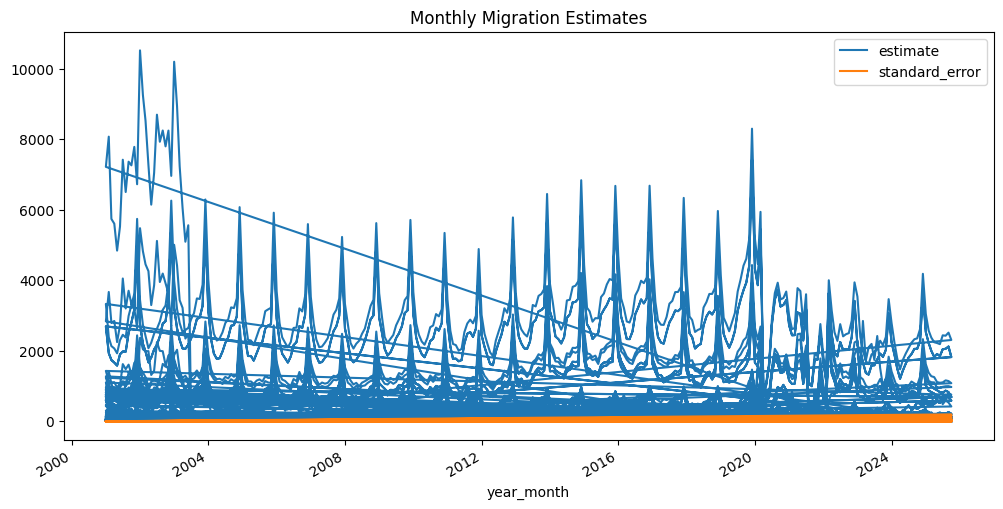

In [5]:
# 1. Data Loading and Preparation
df = pd.read_csv('/content/international-migration-october-2025-citizenship-by-visa-and-by-country-of-last-permanent-residence.csv', index_col='year_month', parse_dates=True)
df.plot(figsize=(12, 6), title='Monthly Migration Estimates')
plt.show()

In [6]:
# 2. Stationarity Check (Augmented Dickey-Fuller Test)
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

check_stationarity(df['estimate'].dropna())

ADF Statistic: -14.399908061615113
p-value: 8.543109098436966e-27


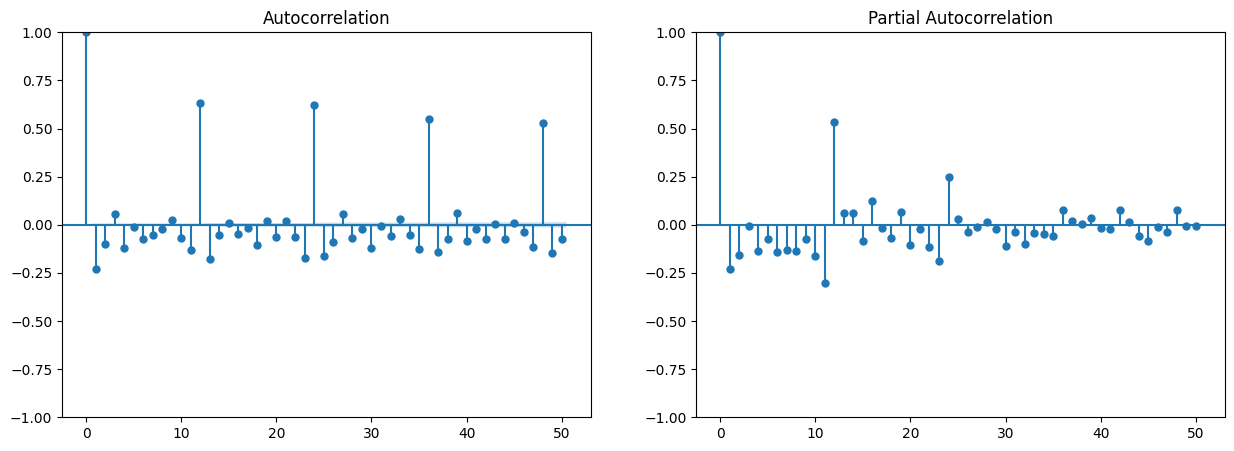

In [7]:
# 3. Differencing and ACF/PACF Analysis
df_diff = df['estimate'].diff().dropna()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(df_diff, ax=ax[0])
plot_pacf(df_diff, ax=ax[1])
plt.show()

In [8]:
# 4. SARIMA Model Fitting
train = df[:-12]
test = df[-12:]

# (p, d, q) x (P, D, Q, s) - Seasonal parameters
model = SARIMAX(train['estimate'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=False)
print(results.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                           estimate   No. Observations:                95691
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood             -568163.228
Date:                            Fri, 02 Jan 2026   AIC                        1136336.455
Time:                                    07:40:07   BIC                        1136383.799
Sample:                                         0   HQIC                       1136350.852
                                          - 95691                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4568      0.001    461.275      0.000       0.455       0.459
ma.L1         -0.6960      0.001   

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


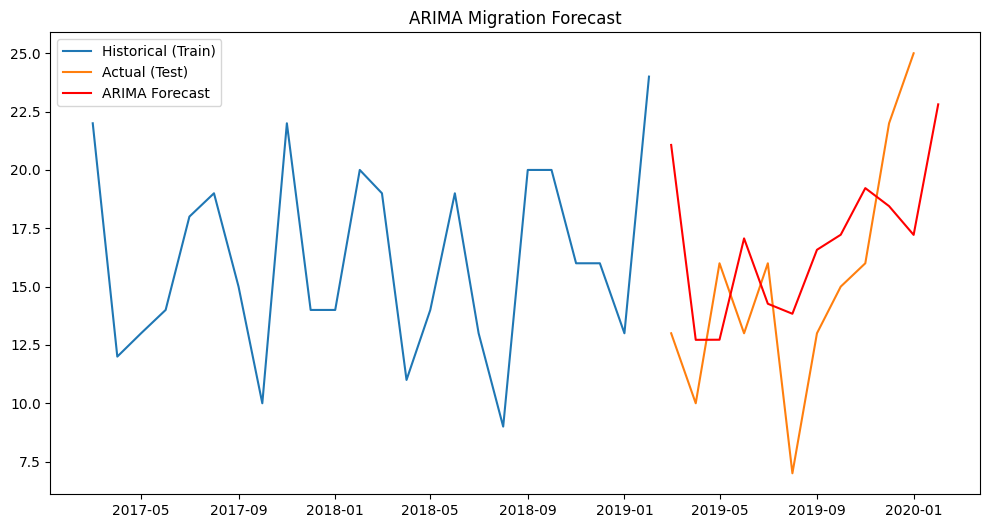

Test RMSE: 4.78


In [11]:
# 5. Forecasting and Evaluation
forecast = results.get_forecast(steps=12).predicted_mean
forecast = pd.Series(forecast.values, index=test.index)

# Ensure both series are aligned and handle potential NaNs before RMSE calculation
# Create a DataFrame to align the actual and forecasted values and drop NaNs
comparison_df = pd.DataFrame({'actual': test['estimate'], 'forecast': forecast})
comparison_df.dropna(inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(train.index[-24:], train['estimate'][-24:], label='Historical (Train)')
plt.plot(test.index, test['estimate'], label='Actual (Test)')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('ARIMA Migration Forecast')
plt.show()

rmse = np.sqrt(mean_squared_error(comparison_df['actual'], comparison_df['forecast']))
print(f'Test RMSE: {rmse:.2f}')